In [17]:
%matplotlib inline

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Using Raw Image

In [14]:
def load_images(path=None):
    if path is None:
        path = os.path.join(os.getcwd(), 'images')

    images = []
    students = []

    for student in os.listdir(path):
        student_path = os.path.join(path, student)
        
        if os.path.isdir(student_path):
        
            for image in os.listdir(student_path):
                image_path = os.path.join(student_path, image)
        
                if os.path.isfile(image_path):
                    image = Image.open(image_path)
                    image = image.convert('L')

                    if image.size != (500, 500):
                        image = image.resize((500, 500))
                    
                    image_vector = np.array(image, dtype=np.float64).flatten()                    
                        
                    images.append(image_vector)
                    students.append(student)
    
    return np.array(images), np.array(students)

In [4]:
def draw(vec, imsize=(500, 500)):
    plt.imshow(vec.reshape(imsize), cmap='gray')

In [10]:
def project(W, X, mean):
    return np.dot(X - mean, W)

In [11]:
def apply_pca(X, num_components=15):
    n, _ = X.shape                     
    
    mean = np.mean(X, axis=0)
    
    centered_data = (X - mean)    
        
    L = np.dot(centered_data, centered_data.T)
    
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    eigenvectors = np.dot(centered_data.T , eigenvectors)

    for i in range(n):
        eigenvectors [: , i] = eigenvectors [: , i] / np.linalg.norm(eigenvectors [: , i])        
    
    idx = np.argsort(-eigenvalues)    
    eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:, idx]
    
    return eigenvalues[:num_components], eigenvectors[:, :num_components], mean

In [12]:
def apply_lda(X, y):
    classes = np.unique(y)
    
    n, d = X.shape                
    
    total_mean = X.mean(axis=0)
    
    # with in class scatter matrix
    sw = np.zeros((d, d))
    
    # between class scatter matrix
    sb = np.zeros((d, d))
    
    for label in classes:
        group = X[np.where(y==label)[0], :]
        
        group_mean = group.mean(axis=0)
        
        sw = sw + np.dot((group - group_mean).T, group - group_mean)
        
        sb = sb + n * np.dot((group_mean - total_mean).T, (group_mean - total_mean))
    
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(sw) * sb)
    
    idx = np.argsort(-eigenvalues.real)    
    eigenvalues, eigenvectors = eigenvalues[idx].real, eigenvectors[:, idx].real
    
    return eigenvalues, eigenvectors

In [13]:
def fisherfaces(X, y):
    n, d = X.shape
    
    n_cls = len(np.unique(y))
    
    eigenvalues_pca, eigenvectors_pca, mean_face = apply_pca(X)
    
    eigenvalues_lda, eigenvectors_lda = apply_lda(project(eigenvectors_pca, X, mean_face), y)
    
    eigenvectors = np.dot(eigenvectors_pca, eigenvectors_lda)
    
    return eigenvalues_lda, eigenvectors, mean_face

In [8]:
def knn_classifier(projections, labels, x, k):          
    distances = [np.linalg.norm(x - pi) for pi in projections]    
    indices = np.argsort(distances)[:k]
    
    k_nearest_labels = [labels[i] for i in indices]
    majority_vote = Counter(k_nearest_labels).most_common(1)
    
    label = majority_vote[0][0]
    
    return label

In [9]:
def predict(X, eigenvectors, projections, labels, meanface, k=3):
    y_pred = []
    
    for image in X:
        p = project(eigenvectors, image.reshape(1, -1), meanface)
        prediction = knn_classifier(projections, labels, p, k)
        y_pred.append(prediction)
    
    return np.array(y_pred)

In [15]:
images, students = load_images()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(images, students, test_size=0.2, random_state=42, stratify=students)

In [19]:
eigenvalues, eigenvectors, mean_face = fisherfaces(x_train, y_train)

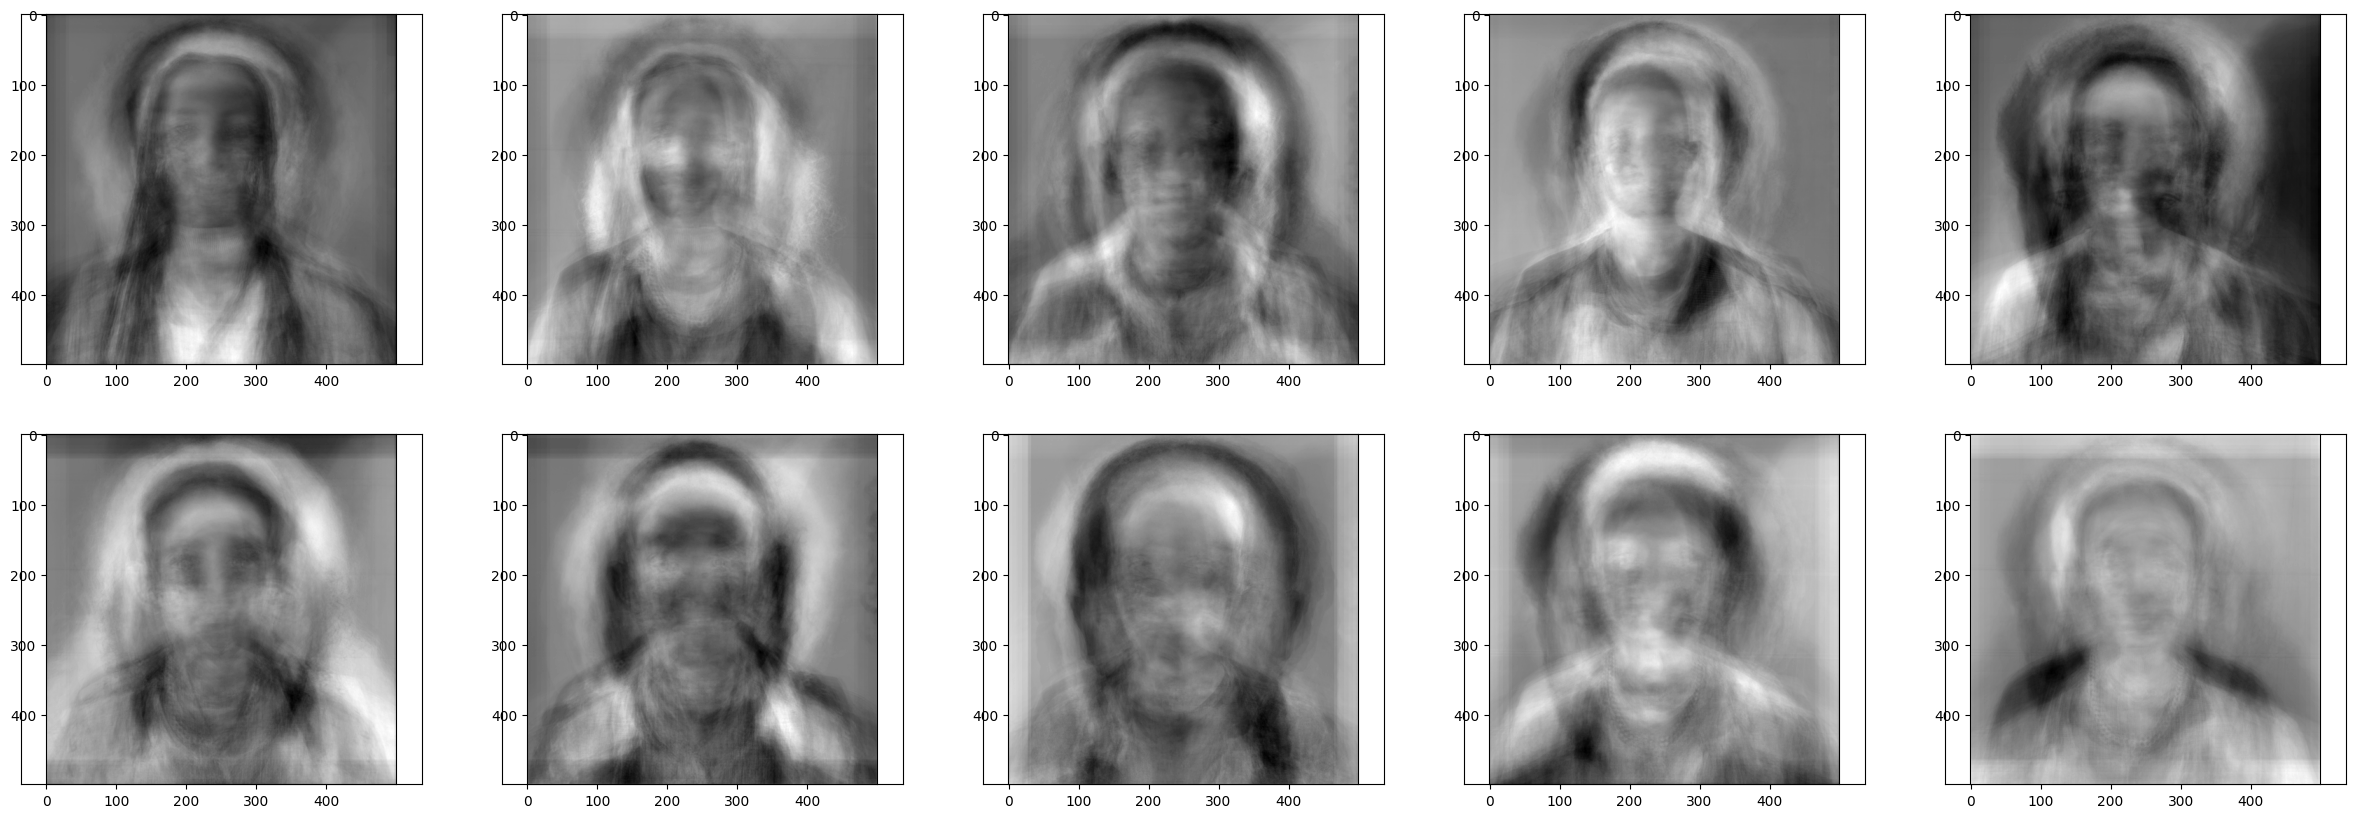

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, face in enumerate(eigenvectors.T[:10]):    
    fig.add_subplot(2, 5, i + 1)
    draw(face)
    
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

In [21]:
projections = []

for image in x_train:
    projections.append(project(eigenvectors, image.reshape(1, -1), mean_face))

projections = np.array(projections)

In [22]:
def confusion_matrix(expected, predicted, classes):        
    c_idx = {cls: idx for idx, cls in enumerate(classes)}
        
    n = len(classes)
    
    cm = np.zeros((n, n))
    
    for y, y_pred in zip(expected, predicted):
        if y in c_idx and y_pred in c_idx:
            idx_y = c_idx[y]
            idx_pred = c_idx[y_pred]

            cm[idx_y][idx_pred] += 1
    
    return cm

In [23]:
def calc_accuracy(expected, predicted):
    return np.sum(expected.flatten() == predicted.flatten()) / len(expected)

In [24]:
y_pred = predict(x_test, 
                 eigenvectors, 
                 projections, 
                 labels=y_train, 
                 meanface = mean_face,
                 k=3)

In [25]:
classes  = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred, classes)

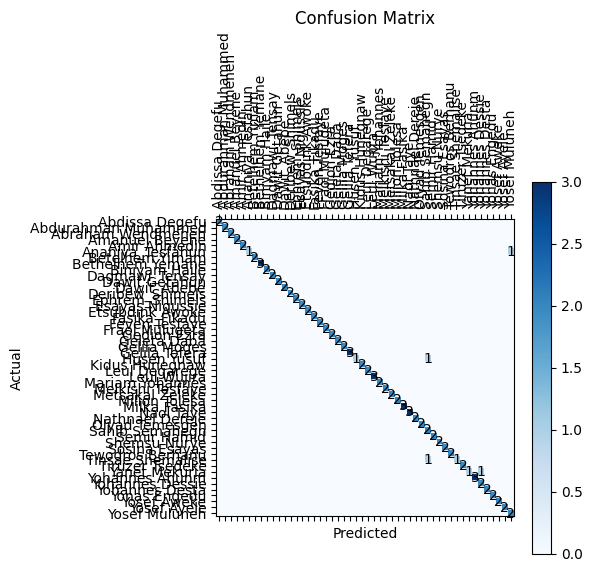

In [26]:
plt.matshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(len(classes)), classes, rotation=90)
plt.yticks(range(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[i, j] > 0:
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [27]:
accuracy = calc_accuracy(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.23%


# Using cropped images

In [33]:
from fisherface import FisherFaces

In [28]:
images, students = load_images('cropped')

In [29]:
x_train, x_test, y_train, y_test = train_test_split(images, students, test_size=0.2, random_state=42, stratify=students)

In [35]:
fisher_recognizer = FisherFaces()

In [37]:
fisher_recognizer.fit(x_train, y_train)

In [45]:
y_pred = fisher_recognizer.transform(x_test)

In [47]:
calc_accuracy(y_pred, y_test)

0.9528301886792453

In [48]:
classes  = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred, classes)

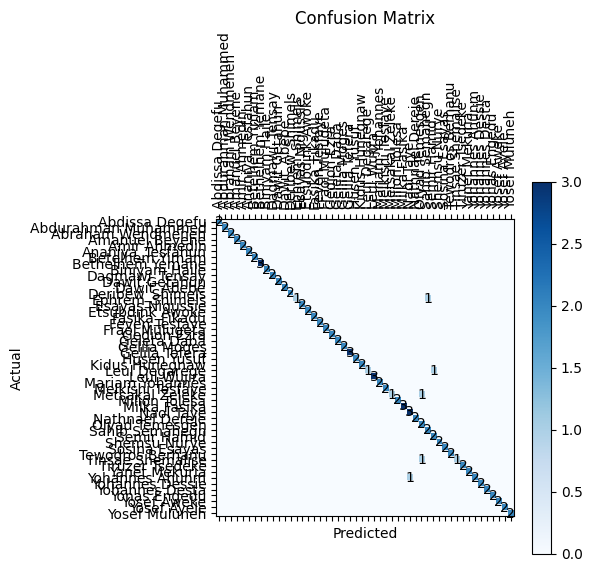

In [49]:
plt.matshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(len(classes)), classes, rotation=90)
plt.yticks(range(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[i, j] > 0:
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()